In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from io import BytesIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ZIP_PATH = "/content/drive/My Drive/Colab Notebooks/cars.zip"


In [ ]:
# Function to extract color histogram from an image
def extract_color_histogram(image, hist_size=8):
    hist = cv2.calcHist([image], [0, 1, 2], None, [hist_size] * 3, [0, 256] * 3)
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [ ]:
def load_dataset_from_zip(zip_path, hist_size=8):
    X, y = [], []
    label_dict = {}

    with zipfile.ZipFile(zip_path, 'r') as archive:
        file_list = [f for f in archive.namelist() if f.endswith(('.jpg', '.png'))]

        for file in file_list:
            parts = file.split('/')
            if len(parts) < 2:
                continue  # Ignore files without a category

            label = parts[1]  # Extract class name from file path
            if label not in label_dict:
                label_dict[label] = len(label_dict)

            with archive.open(file) as img_file:
                img_data = img_file.read()
                img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)

                if img is not None:
                    features = extract_color_histogram(img, hist_size)
                    X.append(features)
                    y.append(label_dict[label])

    return np.array(X), np.array(y), label_dict

In [ ]:
# Load images and extract features
X, y, label_dict = load_dataset_from_zip(ZIP_PATH)

In [ ]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Finding the best k value
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
best_k = 1
best_accuracy = 0

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    val_pred = knn.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"k={k}: Validation Accuracy = {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_k = k

print(f"Best k: {best_k}")

k=1: Validation Accuracy = 0.5063
k=3: Validation Accuracy = 0.5082
k=5: Validation Accuracy = 0.5005
k=7: Validation Accuracy = 0.5014
k=9: Validation Accuracy = 0.5066
k=11: Validation Accuracy = 0.4949
k=13: Validation Accuracy = 0.4934
k=15: Validation Accuracy = 0.4955
Best k: 3


In [ ]:
# Train final k-NN model with best k
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Evaluate on test set
y_pred = final_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
print("Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Test Set Performance:
Accuracy: 0.4924
Precision: 0.4928
Recall: 0.4924
F1-score: 0.4924


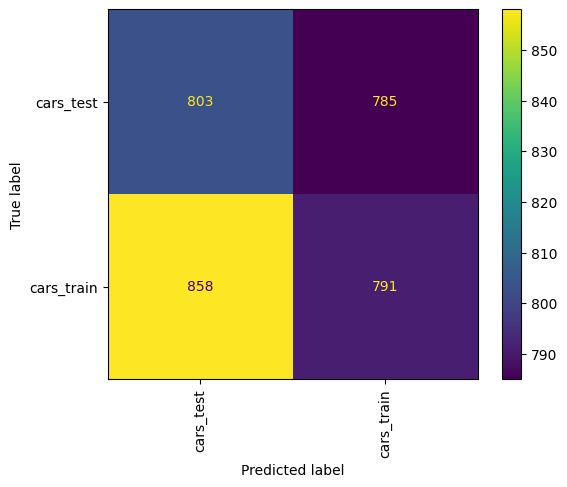

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_dict.keys()))
disp.plot(xticks_rotation=90)
plt.show()